# Newsvendor Problem

## Background

The classic [newsvendor problem or newsvendor model](https://en.wikipedia.org/wiki/Newsvendor_model) is a well-known example of a two stage decision problem. It is a more general problem than the name might suggest with application to situations where a decision is made "here and now" regarding the purchase of perishable goods that will be sold later in a market with uncertain demand. If the vendor buys too much then there will be leftover goods that will be sold for salvage value. Buy too little and the vendor leaves "money on the table." The problem is find the right amount of goods to purchase that balances economic risk and reward.

The newsvendor model is found in range of applications, including in media at [Time Magazine](https://pubsonline.informs.org/doi/abs/10.1287/inte.33.3.72.16010?journalCode=inte) and the [Yedioth Group](https://pubsonline.informs.org/doi/abs/10.1287/inte.2014.0759?journalCode=inte), manufacturing at [Intel](https://pubsonline.informs.org/doi/abs/10.1287/inte.1070.0339?journalCode=inte) and [Hitachi](https://pubsonline.informs.org/doi/abs/10.1287/inte.1070.0299?journalCode=inte), [supply chain optimization in online fashion e-commerce](https://arxiv.org/pdf/2007.02510.pdf), and [recycling/remanufacturing operations](https://econpapers.repec.org/bookchap/sprisochp/978-1-4614-3600-3_5f10.htm).

Recent reviews of the literature can be found at

* Petruzzi, N. C., & Dada, M. (1999). Pricing and the newsvendor problem: A review with extensions. Operations research, 47(2), 183-194. [doi](https://pubsonline.informs.org/doi/10.1287/opre.47.2.183)

* Qin, Y., Wang, R., Vakharia, A. J., Chen, Y., & Seref, M. M. (2011). The newsvendor problem: Review and directions for future research. European Journal of Operational Research, 213(2), 361-374. [doi](https://doi.org/10.1016/j.ejor.2010.11.024)

* Choi, T. M. (Ed.). (2012). Handbook of Newsvendor problems: Models, extensions and applications (Vol. 176). Springer Science & Business Media. [Springer](https://link.springer.com/book/10.1007/978-1-4614-3600-3)

Daily life is replete with examples of the newsvendor problem. Stop a moment and think of a few before moving on.

## Problem Data

The vendor needs to decide how much inventory to order here and now to fulfill an uncertain demand that won't be known until later. The data includes the purchase cost $c$, the retail selling price $r$, and salvage/waste value $w$. The problem has meaning when these prices satisfy relationships

$$ r \geq c \geq w$$

The difference $(r - c)$ is the net profit earned per unit when there is sufficient customer demand, $(c - w)$ is the loss per unit for goods sold as waste or salvage.

| | Symbol | Value |
| :-- | :--: | :--: |
| Retail price | $r$ | 5.00 | 
| Purchase cost | $c$ | 2.00 |
| Waste/Salvage value | $w$ | 1.25 |

A probabilistic forecast for demand is specified as a set of scenarios.

| Scenario | Probability | Demand |
| :--: | :--: | :--: |
| A | 0.7 | 2000 |
| B | 0.3 | 1000 |


In [120]:
import numpy as np
import pandas as pd

r = 5
c = 2
w = 1.25

scenarios = pd.DataFrame({
    "A": {"probability": 0.6, "demand": 2000},
    "B": {"probability": 0.4, "demand": 1000},
}).T

display(scenarios)

,probability,demand
A,0.6,2000.0
B,0.4,1000.0


## Preliminary Calculations

### Expected Value with Perfect Information (EV|PI)

Imagine a situation where one could forecast future demand perfectly. Then for each scenario $s \in S$, the order size would match demand $D_s$ producing a net profit $(r - c)D_s$ with probability $p_s$. The computing expected value then gives the **expected value of perfect information (EV|PI)**

$$
\begin{align*}
\mathbb{E}[P|PI] & = \sum_{s\in S} p_s (r-c) D_s \\
& = (r - c) \sum_{s\in S} p_s D_s \\
\\
\implies \mathbb{E}[P|PI] & = (r - c) \mathbb{E}[D] \\
\end{align*}
$$

EVPI establishes an upper bound on the expected return.

In [121]:
evpi = (r - c) * sum(scenarios["probability"] * scenarios["demand"])
print(f"Expected Value of Perfect Information = {evpi:0.2f}")

Expected Value of Perfect Information = 4800.00


### Computing the Expected Value for fixed Order Size

The key characteristic of the newsvendor problem is that one determines the order size $x$ without advance knowledge of which scenario will transpire. For scenarios $s\in S$, the number of units sold at retail value is given by the smaller of the order size and demand.

$$
\begin{align*}
y_s & = \min(x, D_s)\\
\end{align*}
$$

The salvage is the left over amount $x - y_s$ which be non-negative. The expected profit is then

$$
\begin{align*}
\mathbb{E}[P|x] & = \sum_{s\in S} p_s \left[ (r-c) y_s - (c - w) (x - y_s) \right] \\
& = \sum_{s\in S} p_s \left[ (r-c) y_s + (c - w) y_s - (c - w) x \right] \\
& = (r - w) \sum_{s\in S} p_s y_s  - (c - w) x \\
\\
\implies \mathbb{E}[P|x] & = (r - w) \mathbb{E}[y] - (c - w) x \\
\\
\implies \mathbb{E}[P|x] & = (r - w) \mathbb{E}[\min(x, D)] - (c - w) x \\
\end{align*}
$$

In [122]:
def expected_profit(x):
    D = scenarios["demand"]
    p = scenarios["probability"]
    y = np.minimum(x, D)    
    return  (r - w)*sum(p*y) - (c - w)*x

### Expected Value of the Mean Demand

A common answer to the question of how much to order is to order the expected demand. 

$$\bar{D} = \mathbb{E}[D] = \sum_{s\in S} p_s D_s$$

The is call the **expected value for the mean demand (EV|MD)** which

$$\mathbb{E}[P|x = \bar{D}] = (r - w) \mathbb{E}[\min(\bar{D}, D)] - (c - w) \bar{D} $$

In [123]:
D = sum(scenarios["probability"] * scenarios["demand"])
print(f"mean demand = {D}")

evmd = expected_profit(D)
print(f"expected profit for the mean demand = {evmd}")

mean demand = 1600.0
expected profit for the mean demand = 3900.0


## Stochastic Solution for Maximum Expected Value

The objective is to maximize expected profit. Let's plot the expected value as a function of the decision variable $x$.

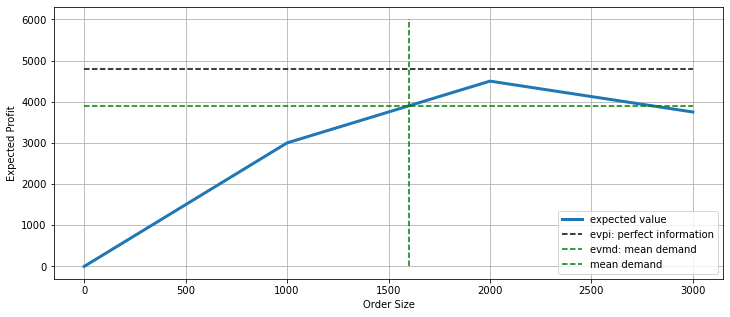

In [126]:
import matplotlib.pyplot as plt

def nv_plot():

    x = np.linspace(0, 1.5 * scenarios["demand"].max(), 1000)
    ev = [expected_profit(x) for x in x]

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    ax.plot(x, ev, lw=3, label="expected value")
    ax.plot([0, 3000], [evpi, evpi], 'k--', label="evpi: perfect information")
    ax.plot([0, 3000], [evmd, evmd], 'g--', label="evmd: mean demand")
    ax.plot([D, D], [0, 6000], 'g--', label="mean demand")
    
    ax.set_xlabel("Order Size")
    ax.set_ylabel("Expected Profit")
    ax.grid(True)
    ax.legend()
    
    return ax

nv_plot();

In [127]:
import pyomo.environ as pyo

m = pyo.ConcreteModel()

# price parameters
m.r = pyo.Param(domain=pyo.NonNegativeReals, initialize=r)
m.c = pyo.Param(domain=pyo.NonNegativeReals, initialize=c)
m.w = pyo.Param(domain=pyo.NonNegativeReals, initialize=w)

assert m.c <= m.r
assert m.w <= m.c

# scenario information
m.S = pyo.Set(initialize=scenarios.index)
m.d = pyo.Param(m.S, initialize=scenarios["demand"])
m.p = pyo.Param(m.S, initialize=scenarios["probability"])

assert sum(m.p[s] for s in m.S) == 1

# decision variables
m.x = pyo.Var(domain=pyo.NonNegativeReals)
m.y = pyo.Var(m.S, domain=pyo.NonNegativeReals)

# Objective
@m.Objective(sense=pyo.maximize)
def expected_profit_obj(m):
    return (m.r - m.w)*sum(m.p[s]*m.y[s] for s in m.S) - (m.c - m.w)*m.x 

@m.Constraint(m.S)
def demand_bound(m, s):
    return m.y[s] <= m.d[s]

@m.Constraint(m.S)
def sales_bound(m, s):
    return m.y[s] <= m.x

pyo.SolverFactory('cbc').solve(m)

m.expected_profit_obj.display()
m.x.display()
m.y.display()


expected_profit_obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 4500.0
x : Size=1, Index=None
    Key  : Lower : Value  : Upper : Fixed : Stale : Domain
    None :     0 : 2000.0 :  None : False : False : NonNegativeReals
y : Size=2, Index=S
    Key : Lower : Value  : Upper : Fixed : Stale : Domain
      A :     0 : 2000.0 :  None : False : False : NonNegativeReals
      B :     0 : 1000.0 :  None : False : False : NonNegativeReals


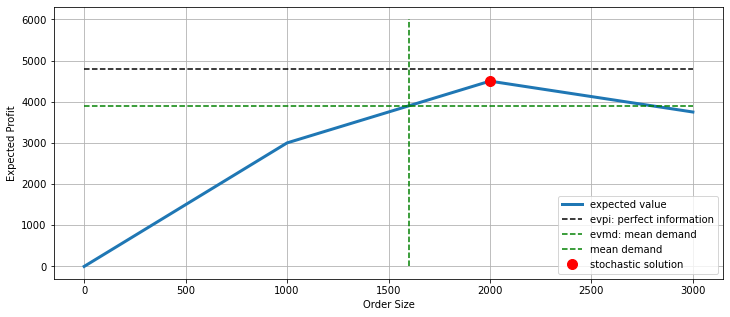

In [128]:
ax = nv_plot()
ax.plot(m.x(), m.expected_profit_obj(), 'r.', ms=20, label="stochastic solution")
ax.legend()

### Maximum Expected Value for Continuous Distributions

For continuous probability distributions

$$
\begin{align*}
\mathbb{E}[P|x] & = (r - w) \mathbb{E}[\min(x, D)] - (c - w) x \\
& = (r - w)\int_0^\infty p(D) \min(x, D)\,dD - (c - w)x \\
& = (r - w)\int_0^x p(D) D\,dD + (r - w) x \int_x^\infty p(D) \,dD - (c - w)x 
\end{align*}
$$

Solving for an unconstrained maximum

$$
\begin{align*}
\left.\frac{\partial \mathbb{E}[P|x]}{\partial x}\right|_{x^{opt}} & = (r - w) \int_{x^{opt}}^\infty p(D) \,dD - (c - w) = 0
\end{align*}
$$

Letting $F(x) = \int_0^x p(D)\,dD$ be the cumulative distribution function and solving for a root

$$
\begin{align*}
(r - w)(1 - F(x^{opt})) - (c - w) & = 0
\end{align*}
$$

$$
\begin{align*}
(r - c) & = (r - w) F(x^{opt}) \\
\\
\implies x^{opt} = F^{-1}\left(\frac{r-c}{r-w}\right)
\end{align*}
$$

## Using Discrete Distribution

In [164]:
q = (r - c)/(r - w)
print(f"quantile = {q}")

quantile = 0.8


,probability,demand,0,cdf
0,0.0,0.0,NaN,NaN
B,0.4,1000.0,demand,0.4
A,0.6,2000.0,probability,1.0
1,0.0,3000.0,NaN,NaN


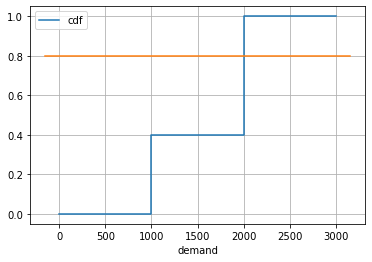

In [165]:
scenarios.loc["0", :] = {"probability": 0, "demand": 0}
scenarios.loc["1", :] = {"probability": 0, "demand": 3000}

scenarios = scenarios.sort_values("demand")
display(scenarios)
scenarios["cdf"] = scenarios["probability"].cumsum()

ax = scenarios.plot(x="demand", y="cdf", drawstyle="steps-post", grid=True)
ax.plot(ax.get_xlim(), [q, q])

mean demand = 1600.00
standard deviation = 489.90
optimal order size = 2012.31


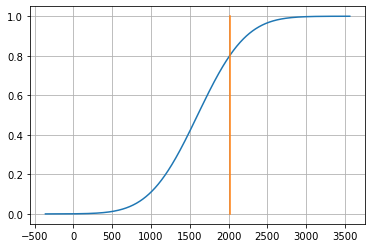

In [137]:
# fit scenario data to normal distribution
D = sum(scenarios["probability"] * (scenarios["demand"]))
sigma = np.sqrt(sum(scenarios["probability"] * (scenarios["demand"]**2)) - D**2)
print(f"mean demand = {D:0.2f}")
print(f"standard deviation = {sigma:0.2f}")


import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

#define x and y values to use for CDF
x = np.linspace(-4, 4, 1000)
y = ss.norm.cdf(x)

#plot normal CDF
fig, ax = plt.subplots(1, 1)
ax.plot(sigma*x + D, y)
xopt = D + sigma * ss.norm.ppf((r-c)/(r-w))


ax.plot([xopt, xopt], [0, 1])
ax.grid(True)

print(f"optimal order size = {xopt:0.2f}")